In [1]:
import keras

In [2]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Setting seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, SimpleRNN, GRU, Activation
%matplotlib inline

In [3]:
# Data ingestion - reading the datasets from Azure blob 
!wget http://azuremlsamples.azureml.net/templatedata/PM_train.txt 
!wget http://azuremlsamples.azureml.net/templatedata/PM_test.txt
!wget http://azuremlsamples.azureml.net/templatedata/PM_truth.txt 

--2021-12-12 12:57:31--  http://azuremlsamples.azureml.net/templatedata/PM_train.txt
Resolving azuremlsamples.azureml.net (azuremlsamples.azureml.net)... 13.107.246.38, 13.107.213.38, 2620:1ec:bdf::38, ...
Connecting to azuremlsamples.azureml.net (azuremlsamples.azureml.net)|13.107.246.38|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3515356 (3.4M) [text/plain]
Saving to: ‘PM_train.txt’

PM_train.txt        100%[===================>]   3.35M  12.0MB/s    in 0.3s    

2021-12-12 12:57:32 (12.0 MB/s) - ‘PM_train.txt’ saved [3515356/3515356]

--2021-12-12 12:57:32--  http://azuremlsamples.azureml.net/templatedata/PM_test.txt
Resolving azuremlsamples.azureml.net (azuremlsamples.azureml.net)... 13.107.246.38, 13.107.213.38, 2620:1ec:bdf::38, ...
Connecting to azuremlsamples.azureml.net (azuremlsamples.azureml.net)|13.107.246.38|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2228855 (2.1M) [text/plain]
Saving to: ‘PM_test.txt’

PM_test.txt

In [4]:
# read training data 
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [5]:
# read test data
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [6]:
# read ground truth data
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

In [7]:
train_df = train_df.sort_values(['id','cycle'])
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


# Предобработка данных

In [8]:
train_df.groupby('id')['cycle'].max()

id
1      192
2      287
3      179
4      189
5      269
      ... 
96     336
97     202
98     156
99     185
100    200
Name: cycle, Length: 100, dtype: int64

In [9]:
# Data Labeling - generate column RUL
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [10]:
# generate label columns for training data
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0,0


In [11]:
# MinMax normalization
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,1.0,0.726248,0.242424,0.109755,0.0,0.369048,0.633262,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,1.0,0.628019,0.212121,0.100242,0.0,0.380952,0.765458,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,1.0,0.710145,0.272727,0.140043,0.0,0.250000,0.795309,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,1.0,0.740741,0.318182,0.124518,0.0,0.166667,0.889126,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,1.0,0.668277,0.242424,0.149960,0.0,0.255952,0.746269,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.01108


In [12]:
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,1.0,0.652174,0.212121,0.127614,0.0,0.208333,0.646055,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,1.0,0.805153,0.166667,0.146684,0.0,0.386905,0.739872,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,1.0,0.685990,0.227273,0.158081,0.0,0.386905,0.699360,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,1.0,0.679549,0.196970,0.105717,0.0,0.255952,0.573561,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,1.0,0.694042,0.166667,0.102396,0.0,0.273810,0.737740,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108


In [13]:
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

In [14]:
# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,1.0,0.652174,0.212121,0.127614,0.0,0.208333,0.646055,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,1.0,0.805153,0.166667,0.146684,0.0,0.386905,0.739872,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,1.0,0.685990,0.227273,0.158081,0.0,0.386905,0.699360,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,1.0,0.679549,0.196970,0.105717,0.0,0.255952,0.573561,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,1.0,0.694042,0.166667,0.102396,0.0,0.273810,0.737740,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138


In [15]:
# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,label1,label2
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,1.0,0.652174,0.212121,0.127614,0.0,0.208333,0.646055,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,1.0,0.805153,0.166667,0.146684,0.0,0.386905,0.739872,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,1.0,0.685990,0.227273,0.158081,0.0,0.386905,0.699360,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,1.0,0.679549,0.196970,0.105717,0.0,0.255952,0.573561,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139,0,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,1.0,0.694042,0.166667,0.102396,0.0,0.273810,0.737740,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138,0,0


# Моделирование

In [16]:
# pick a large window size of 50 cycles
sequence_length = 50

Id двигателя по варианту 31

In [17]:
# preparing data for visualizations 
# window of 50 cycles prior to a failure point for engine id 31
engine_id31 = test_df[test_df['id'] == 31]
engine_id31_50cycleWindow = engine_id31[engine_id31['RUL'] <= engine_id31['RUL'].min() + 50]
cols1 = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10']
engine_id31_50cycleWindow1 = engine_id31_50cycleWindow[cols1]
cols2 = ['s11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
engine_id31_50cycleWindow2 = engine_id31_50cycleWindow[cols2]

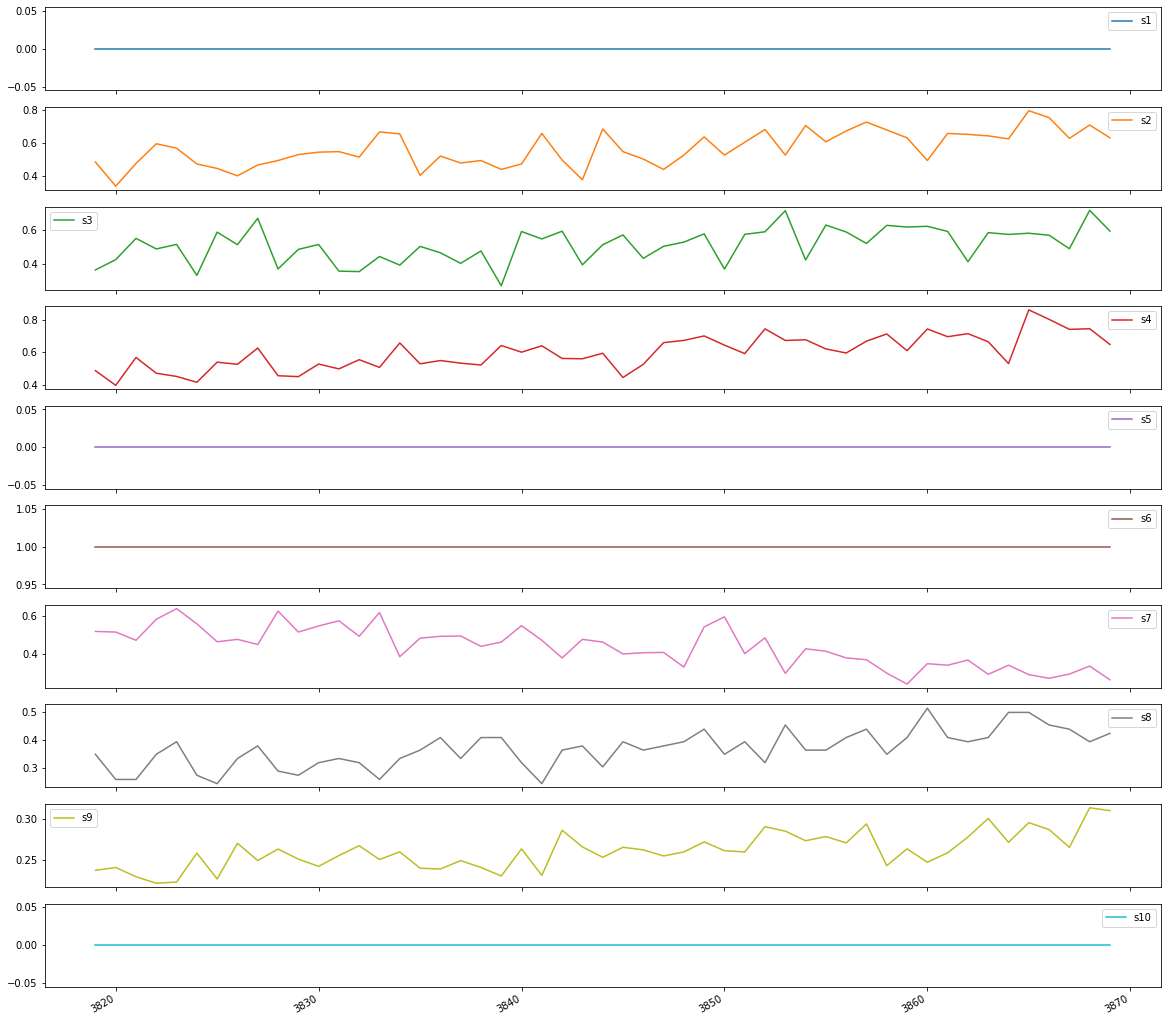

In [18]:
# plotting sensor data for engine ID 3 prior to a failure point - sensors 1-10 
ax1 = engine_id31_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

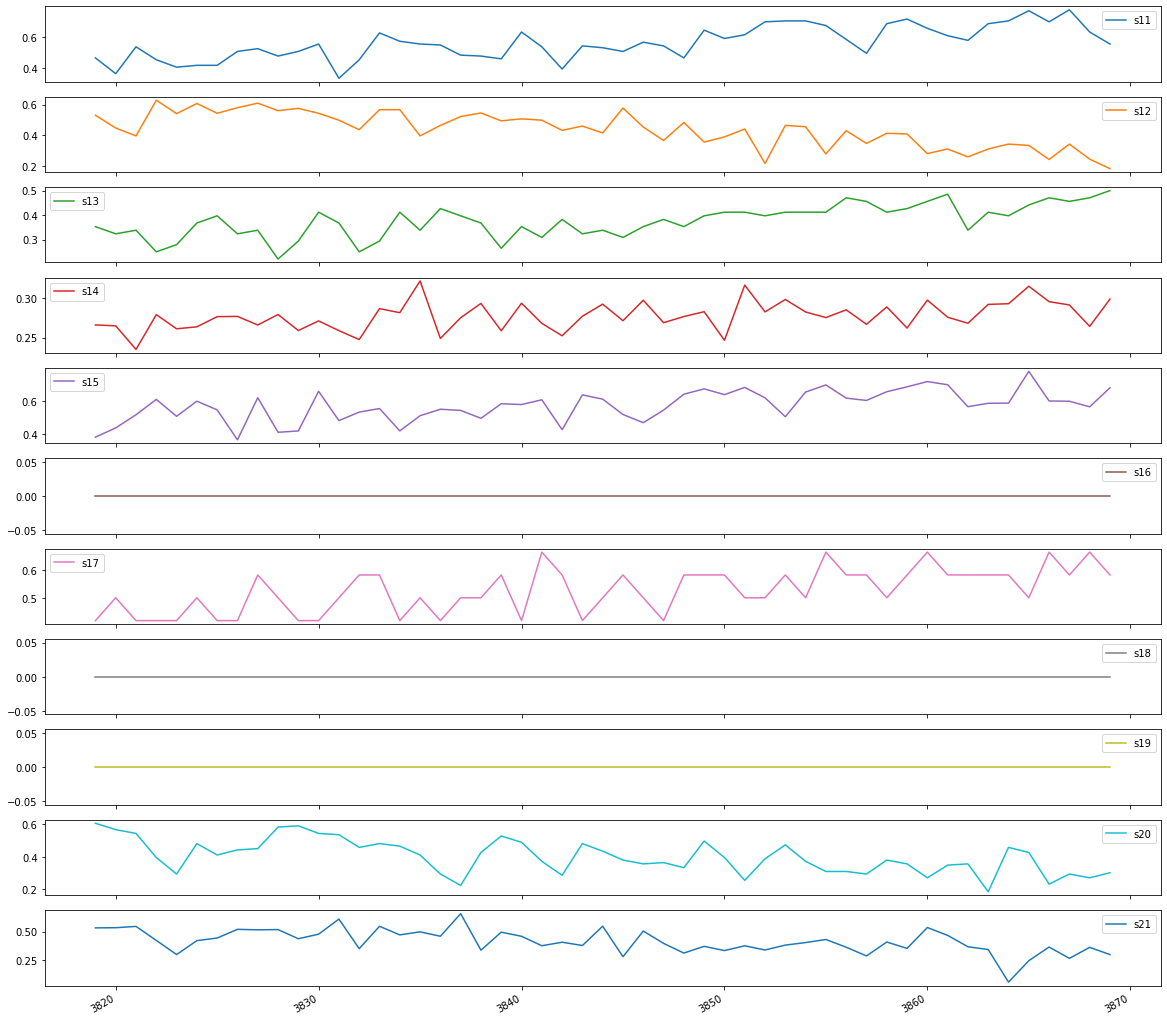

In [19]:
# plotting sensor data for engine ID 3 prior to a failure point - sensors 11-21 
ax2 = engine_id31_50cycleWindow2.plot(subplots=True, sharex=True, figsize=(20,20))

In [20]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

In [21]:
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

In [22]:
# generator for the sequences
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

In [23]:
# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(15631, 50, 25)

In [24]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [25]:
# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

# LSTM сеть

In [26]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Sequential() - класс, создает группу слоев, на которых будет основана модель нейронной сети<br>

add() - добавляет слой к объявленной последовательности <br>
LSTM() - слой долгой краткосрочной памяти, способный к обучению долговременным зависимостям
Используемые параметры:<br>
- input_shape - размер входного пакета нейронной сети
- units - выходной параметр слоя, который будет входом в следующий слой
- return_sequences - True для того, чтобы слой возвращал последовательность, необходимую для входа в следующий слой<br>

Dropout() - Слой случайным образом устанавливает для входных единиц значение 0 с частотой rate (0.2) на каждом шаге во время обучения, что помогает предотвратить переобучение<br>

Dense() - Полносвязный слой нейросети
Исползуемые параметры:
- units - выходной параметр слоя
- activation - функция активации слоя, в данном случае sigmoid возвращает значение от 0 до 1<br>

compile() - Настраивает модель для обучения<br>
Используемые параметры:<br>
- loss - функция потерь, в данном случае binary_crossentropy подходит в случае предсказания 2-х классов
- optimizer - используемый оптимизатор adam популярный алгоритм в области глубокого обучения, потому что он быстро дает хорошие результаты
- metrics - это функция, которая используется для оценки производительности вашей модели, в данном случае accuracy 

In [27]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           50400     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________
None


Слой lstm: для слоёв LSTM число параметров высчитывается по формуле <br>
$params = 4 * ((size\_of\_input + 1) * size\_of\_output + size\_of\_output^2)$
<br> Отсюда следует, что:<br>
$params = 4 * ((25 + 1) * 100 + 100^2) = 50400$

То же самое со слоем lstm_1, только здесь размер входных данных будет 100, а выходных 50<br>

$params = 4 * ((100 + 1) * 50 + 50^2) = 30200$<br>

Для слоя dense формула будет такой:<br>
$params = size\_of\_output * (size\_of\_input + 1)$<br>
В результате:<br>
$params = 1 * (50 + 1) = 51$

Слои Dropout всегда будут иметь значение 0, причина в том, что эти слои ничего не учат<br>
В результате общее количество параметров равно сумме параметров в слоях

## Выполнение на CPU

In [45]:
cpu_time_lstm = time.time()
# fit the network
history = model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
cpu_time_lstm = time.time() - cpu_time_lstm

Epoch 1/10
75/75 [==============================] - 12s 160ms/step - loss: 0.0756 - accuracy: 0.9692 - val_loss: 0.0717 - val_accuracy: 0.9629
Epoch 2/10
75/75 [==============================] - 12s 159ms/step - loss: 0.0804 - accuracy: 0.9666 - val_loss: 0.0555 - val_accuracy: 0.9795


In [46]:
cpu_time_lstm

23.984781742095947

## Выполнение на GPU

In [31]:
gpu_time_lstm = time.time()
# fit the network
history = model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
gpu_time_lstm = time.time() - gpu_time_lstm

Epoch 1/10
75/75 [==============================] - 3s 35ms/step - loss: 0.0843 - accuracy: 0.9657 - val_loss: 0.0436 - val_accuracy: 0.9847
Epoch 2/10
75/75 [==============================] - 2s 33ms/step - loss: 0.0784 - accuracy: 0.9694 - val_loss: 0.0357 - val_accuracy: 0.9859


In [32]:
gpu_time_lstm

5.27718448638916

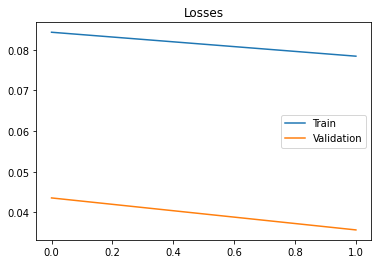

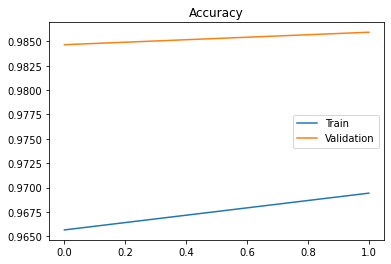

In [33]:
plt.title('Losses')
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.show()

plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.legend()
plt.show()

fit() - Обучает модель<br>
первый параметр это входные данные, здесь входными данными выступают seq_array - различные характеристики с сенсоров<br>
второй параметр - целевые данные label_array - метки выхода из строя<br>
epochs - количество эпох обучения<br>
batch_size - определяет количество выборок, которые будут распространяться по сети<br>
validation_split - Часть обучающих данных, которая будет использоваться в качестве данных проверки. Модель выделит эту часть обучающих данных, не будет обучаться на ней и будет оценивать потери и любые метрики модели на этих данных в конце каждой эпохи<br>
verbose - режим детализации (0 = ничего, 1 = индикатор выполнения, 2 = одна строка на эпоху)<br>
callbacks - Список обратных вызовов для вызова во время обучения, в данном случае используется EarlyStopping (ранняя остановка)<br>
Параметры по которым срабатывает EarlyStopping:<br>
- monitor - величина, которая мониторится, в данном случае это потери на валидационной выборке
- min_delta - минимальное изменение отслеживаемой величины, которое квалифицируется как улучшение
- patience - количество эпох без улучшения, после которых обучение будет остановлено
- verbose - режим детализации
- mode - В auto режиме обучение остановится, когда отслеживаемая величина перестанет уменьшаться или увеличиваться, в данном случае val_loss должен уменьшатьтся


In [34]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

79/79 [==============================] - 1s 14ms/step - loss: 0.0591 - accuracy: 0.9739
Accurracy: 0.9738979935646057


In [35]:
# make predictions and compute confusion matrix
y_pred = (model.predict(seq_array,verbose=1, batch_size=200) > 0.5).astype("int32")
y_true = label_array
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
cm

79/79 [==============================] - 2s 11ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[12259,   272],
       [  136,  2964]])

In [36]:
# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

precision =  0.9159456118665018 
 recall =  0.9561290322580646


In [37]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(93, 50, 25)

In [38]:
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]

In [39]:
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
label_array_test_last.shape

(93, 1)

In [40]:
print(seq_array_test_last.shape)
print(label_array_test_last.shape)

(93, 50, 25)
(93, 1)


In [41]:
# test metrics
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

3/3 - 0s - loss: 0.0605 - accuracy: 0.9677 - 45ms/epoch - 15ms/step
Accurracy: 0.9677419066429138


In [42]:
# make predictions and compute confusion matrix
y_pred_test = (model.predict(seq_array_test_last) > 0.5).astype("int32")
y_true_test = label_array_test_last
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
cm

Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[67,  1],
       [ 2, 23]])

In [43]:
# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

Precision:  0.9583333333333334 
 Recall:  0.92 
 F1-score: 0.9387755102040817


In [44]:
results_df = pd.DataFrame([[scores_test[1],precision_test,recall_test,f1_test]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['LSTM'])
results_df

,Accuracy,Precision,Recall,F1-score
LSTM,0.967742,0.958333,0.92,0.938776


# RNN

In [45]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(SimpleRNN(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(SimpleRNN(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50, 100)           12600     
                                                                 
 dropout_2 (Dropout)         (None, 50, 100)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50)                7550      
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 20,201
Trainable params: 20,201
Non-trainable params: 0
_________________________________________________________________
None


Здесь для слоя SimpleRNN число параметров вычисляется по формуле<br>
$params = (num\_features + num\_units)* num\_units + biases$<br><br>
$params = (25+100) * 100 + 100$<br>
Аналогично для второго слоя<br>
$params = (100+50) * 50 + 50$

In [56]:
cpu_time_rnn = time.time()
# fit the network
history = model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
cpu_time_rnn = time.time() - cpu_time_rnn

Epoch 1/10
75/75 [==============================] - 4s 54ms/step - loss: 0.1030 - accuracy: 0.9589 - val_loss: 0.1028 - val_accuracy: 0.9501
Epoch 2/10
75/75 [==============================] - 4s 54ms/step - loss: 0.0960 - accuracy: 0.9600 - val_loss: 0.0736 - val_accuracy: 0.9693


In [57]:
cpu_time_rnn

8.146860837936401

In [50]:
gpu_time_rnn = time.time()
# fit the network
history = model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
gpu_time_rnn = time.time() - gpu_time_rnn

Epoch 1/10
75/75 [==============================] - 11s 147ms/step - loss: 0.1153 - accuracy: 0.9519 - val_loss: 0.1172 - val_accuracy: 0.9488
Epoch 2/10
75/75 [==============================] - 11s 144ms/step - loss: 0.0955 - accuracy: 0.9599 - val_loss: 0.1139 - val_accuracy: 0.9514


In [51]:
gpu_time_rnn

21.917987823486328

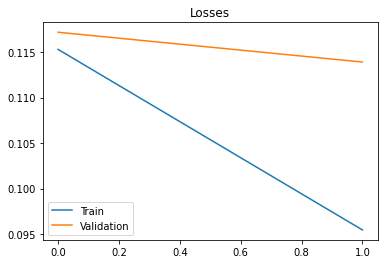

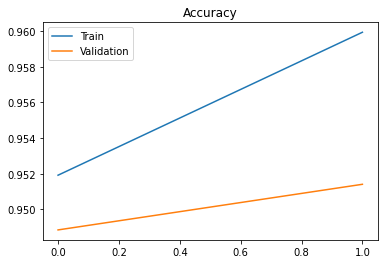

In [52]:
plt.title('Losses')
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.show()

plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.legend()
plt.show()

In [53]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

79/79 [==============================] - 1s 17ms/step - loss: 0.0904 - accuracy: 0.9683
Accurracy: 0.9683321714401245


In [54]:
# make predictions and compute confusion matrix
y_pred = (model.predict(seq_array,verbose=1, batch_size=200) > 0.5).astype("int32")
y_true = label_array
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
cm

79/79 [==============================] - 1s 15ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[12360,   171],
       [  324,  2776]])

In [55]:
# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

precision =  0.9419748897183576 
 recall =  0.895483870967742


In [56]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(93, 50, 25)

In [57]:
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]

In [58]:
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
label_array_test_last.shape

(93, 1)

In [59]:
print(seq_array_test_last.shape)
print(label_array_test_last.shape)

(93, 50, 25)
(93, 1)


In [60]:
# test metrics
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

3/3 - 0s - loss: 0.2025 - accuracy: 0.9570 - 69ms/epoch - 23ms/step
Accurracy: 0.9569892287254333


In [61]:
# make predictions and compute confusion matrix
y_pred_test = (model.predict(seq_array_test_last) > 0.5).astype("int32")
y_true_test = label_array_test_last
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
cm

Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[68,  0],
       [ 4, 21]])

In [62]:
# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

Precision:  1.0 
 Recall:  0.84 
 F1-score: 0.9130434782608696


In [63]:
res = pd.DataFrame([[scores_test[1],precision_test,recall_test,f1_test]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['RNN'])
results_df = results_df.append(res)
results_df

,Accuracy,Precision,Recall,F1-score
LSTM,0.967742,0.958333,0.92,0.938776
RNN,0.956989,1.000000,0.84,0.913043


# GRU

In [64]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(GRU(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [65]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50, 100)           38100     
                                                                 
 dropout_4 (Dropout)         (None, 50, 100)           0         
                                                                 
 gru_1 (GRU)                 (None, 50)                22800     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 60,951
Trainable params: 60,951
Non-trainable params: 0
_________________________________________________________________
None


Здесь для слоя GRU число параметров вычисляется по формуле<br>
$params = ((input + output) * output + output + output) * bias$ <br>
Так для первого слоя<br>
$params = ((25 + 100)*100 + 100 + 100) * 3 = 38100$
Аналогично для второго<br>
$params = ((100+50)*50 + 50 + 50) * 3 = 22800$


In [75]:
cpu_time_gru = time.time()
# fit the network
history = model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
cpu_time_gru = time.time() - cpu_time_gru

Epoch 1/10
75/75 [==============================] - 14s 152ms/step - loss: 0.2460 - accuracy: 0.8997 - val_loss: 0.1645 - val_accuracy: 0.9297
Epoch 2/10
75/75 [==============================] - 11s 144ms/step - loss: 0.1367 - accuracy: 0.9416 - val_loss: 0.1294 - val_accuracy: 0.9399


In [76]:
cpu_time_gru

25.100087642669678

In [66]:
gpu_time_gru = time.time()
# fit the network
history = model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
gpu_time_gru = time.time() - gpu_time_gru

Epoch 1/10
75/75 [==============================] - 7s 45ms/step - loss: 0.2752 - accuracy: 0.8776 - val_loss: 0.1723 - val_accuracy: 0.9271
Epoch 2/10
75/75 [==============================] - 2s 33ms/step - loss: 0.1361 - accuracy: 0.9430 - val_loss: 0.0910 - val_accuracy: 0.9552


In [67]:
gpu_time_gru

9.809988975524902

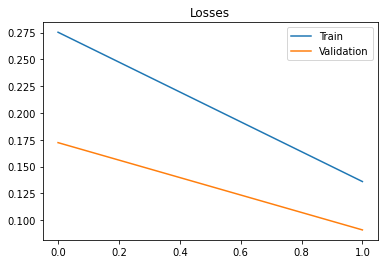

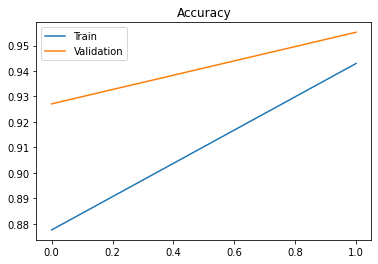

In [68]:
plt.title('Losses')
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.show()

plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.legend()
plt.show()

In [69]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

79/79 [==============================] - 1s 13ms/step - loss: 0.0936 - accuracy: 0.9602
Accurracy: 0.9602072834968567


In [70]:
# make predictions and compute confusion matrix
y_pred = (model.predict(seq_array,verbose=1, batch_size=200) > 0.5).astype("int32")
y_true = label_array
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
cm

79/79 [==============================] - 2s 10ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[12147,   384],
       [  238,  2862]])

In [71]:
# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

precision =  0.8817005545286506 
 recall =  0.9232258064516129


In [72]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(93, 50, 25)

In [73]:
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]

In [74]:
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
label_array_test_last.shape

(93, 1)

In [75]:
print(seq_array_test_last.shape)
print(label_array_test_last.shape)

(93, 50, 25)
(93, 1)


In [76]:
# test metrics
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

3/3 - 0s - loss: 0.1100 - accuracy: 0.9462 - 48ms/epoch - 16ms/step
Accurracy: 0.9462365508079529


In [77]:
# make predictions and compute confusion matrix
y_pred_test = (model.predict(seq_array_test_last) > 0.5).astype("int32")
y_true_test = label_array_test_last
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
cm

Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[67,  1],
       [ 4, 21]])

In [78]:
# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

Precision:  0.9545454545454546 
 Recall:  0.84 
 F1-score: 0.8936170212765958


In [79]:
res = pd.DataFrame([[scores_test[1],precision_test,recall_test,f1_test]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['GRU'])
results_df = results_df.append(res)
results_df

,Accuracy,Precision,Recall,F1-score
LSTM,0.967742,0.958333,0.92,0.938776
RNN,0.956989,1.000000,0.84,0.913043
GRU,0.946237,0.954545,0.84,0.893617


<BarContainer object of 6 artists>

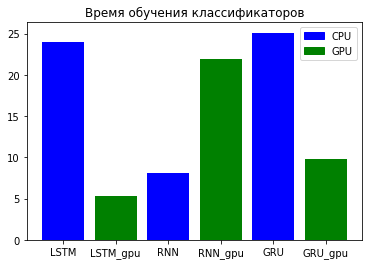

In [81]:
compare_data = [23.984781742095947, gpu_time_lstm,8.146860837936401, gpu_time_rnn,25.100087642669678, gpu_time_gru]
axis = ['LSTM', 'LSTM_gpu', 'RNN', 'RNN_gpu', 'GRU', 'GRU_gpu']
plt.title("Время обучения классификаторов")
colors = {'CPU':'blue', 'GPU':'green'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.bar(axis, compare_data, color=['blue', 'green', 'blue', 'green', 'blue', 'green',])

# Выводы

Время обучения классификаторов на GPU быстрее, чем на CPU, но не в случае с RNN моделью нейросети<br>
По метрике Accuracy лучше всего себя показывает модель с LSTM слоями **(0.967742)**<br>
По Precision лучше всего себя показывает модель с RNN слоями **(1.000000)**<br>
По Recall - LSTM **(0.92)**<br>
По F1-score - так же LSTM **(0.938776)**<br>

В итоге лучшей моделью для набора данных по id двигателя = 31 стала модель с **LSTM** слоями
